<a href="https://colab.research.google.com/github/billyleer97/Future-Prices-Prediction/blob/main/Future_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data

Using kaggle api to download data. 

I will be using guidance from this notebook mainly so all credit to this notebook:
https://www.kaggle.com/jerifate/future-sales-time-series-visualization/data


In [5]:
!pip install kaggle
from google.colab import files


files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bigbillsinthehouse","key":"76e066fb45dc64c45b362b0bc67d508f"}'}

In [6]:
import csv as csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile 

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 54.6MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.27MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.96MB/s]
  0% 0.00/13.3M [00:00<?, ?B/s]
100% 13.3M/13.3M [00:00<00:00, 121MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 139MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 148MB/s]


# Preparing Data

now I will read the data into a pandas dataframe, and check for null values, get a better sense of the shape and size of dataset. 

In [104]:
train_data = pd.read_csv('sales_train.csv.zip', compression='zip')
test_data = pd.read_csv('test.csv.zip', compression='zip')

In [105]:
# pd.set_option('display.max_rows', 500) # unnecessary 
# pd.set_option('display.max_columns', 500) #unnecessary for this dataset, sometimes nice to see the whole set
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


6 columns, but very extensive data set in terms of items. Date value is going to need some engineering to make use of for sure. We have supplemental data, we could join together through sql-esque data merging.



In [106]:
train_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


check for null values

In [107]:
train_data.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

no null values in any of the 6 columns. Now let's check the supplemental information. 


In [108]:
train_data['date'].value_counts()

28.12.2013    9434
29.12.2013    9335
30.12.2014    9324
30.12.2013    9138
31.12.2014    8347
              ... 
14.05.2015    1174
28.04.2015    1154
06.10.2015    1152
13.05.2015    1128
12.05.2015    1123
Name: date, Length: 1034, dtype: int64

In [109]:
items = pd.read_csv('items.csv.zip', compression='zip')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [110]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [111]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Unsure how much shop name will help, if we already have ID. SO I will not be merging this onto the dataset. 

In [112]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [113]:
items_table = pd.merge(items, item_categories, how='left', on='item_category_id')

items_table.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD


In [114]:
train_data.head()
#items_table['item_category_name'].value_counts()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [115]:
full_data = pd.merge(train_data, items_table, how='inner', on='item_id')

full_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,23.01.2013,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,20.01.2013,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,02.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,03.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [116]:
full_data['date'] = pd.to_datetime(full_data['date'])

In [117]:
full_data['date_block_num'].unique()

array([ 0,  1,  2,  3,  7,  8,  9, 11, 30, 31, 32, 33,  4,  6, 17, 28,  5,
       10, 12, 13, 14, 18, 19, 21, 15, 24, 16, 20, 22, 23, 25, 26, 27, 29])

# Check outliers

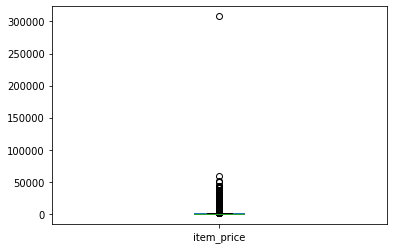

In [118]:
full_data['item_price'].plot(kind='box', showfliers='False')

In [119]:
full_data['item_price'].sort_values()

56049          -1.0000
1117532         0.0700
798519          0.0700
960084          0.0875
1029366         0.0900
              ...     
2934260     42990.0000
2771879     49782.0000
2294618     50999.0000
1180083     59200.0000
2163826    307980.0000
Name: item_price, Length: 2935849, dtype: float64

There is a negative price, and a huge outlier sale price in 307980.0000. we will definitely remove these. Everything else may be fair game. 

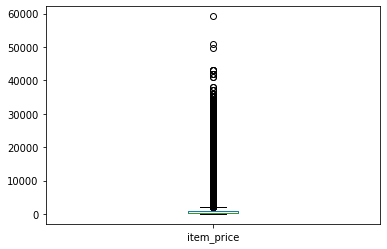

In [120]:
full_data = full_data.drop(full_data[full_data['item_price']<0].index)
full_data = full_data.drop(full_data[full_data['item_price']>300000].index)

full_data['item_price'].plot(kind='box', showfliers='False')

Nevermind. Maybe not fair game. Still extremely right skewed. This does not look good. We will have to remove further. 

In [121]:
series = full_data['item_price']

Q1 = series.quantile(.25)
Q3 = series.quantile(.75)
IQR = Q3-Q1

((series<(Q1-1.5*IQR)) | (series>(Q3+1.5*IQR))).sum()

258941

258941 is a lot. Let's try to reduce those numbers. reference: https://www.kaggle.com/ffsniceboobs/feature-engineering-model-tuning-and-stacking#Step-1.-First-look-at-the-data

In [122]:
low = series.quantile(0.01)
high = series.quantile(0.99)

full_data[(series < low) | (series > high)].shape

(35031, 9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


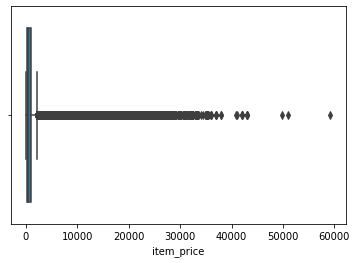

In [123]:
sns.boxplot(full_data['item_price'])

In [124]:
with pd.option_context("display.float_format", lambda x: "%.2f" % x):
  print(full_data['item_price'].describe())

count   2935847.00
mean        890.75
std        1720.49
min           0.07
25%         249.00
50%         399.00
75%         999.00
max       59200.00
Name: item_price, dtype: float64


will remove all datapoints 40,000 and up.

In [125]:
# full_data = full_data.drop(full_data[full_data['item_price']<0].index)
full_data = full_data.drop(full_data[full_data['item_price']>=40000].index)

In [126]:
full_data.dtypes

date                  datetime64[ns]
date_block_num                 int64
shop_id                        int64
item_id                        int64
item_price                   float64
item_cnt_day                 float64
item_name                     object
item_category_id               int64
item_category_name            object
dtype: object

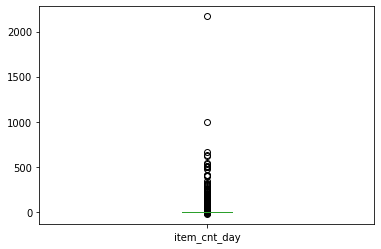

In [127]:
full_data['item_cnt_day'].plot(kind='box')

In [128]:
full_data['item_cnt_day'].sort_values()

906649      -22.0
1488007     -16.0
2454331      -9.0
1176639      -6.0
1776803      -6.0
            ...  
2832929     624.0
2857896     637.0
2858746     669.0
1494614    1000.0
1181188    2169.0
Name: item_cnt_day, Length: 2935834, dtype: float64

So someone made 1000 purchases, and 2169 purchases in one day? interesting. There are negative numbers which are also interesting. 

In [129]:
full_data[(full_data['item_cnt_day']<0 )]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
60,2013-05-01,0,25,2552,899.0,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
64,2013-05-14,4,6,2552,949.0,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
1985,2014-07-07,18,31,2574,399.0,-1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
2543,2015-06-26,29,16,2574,449.0,-1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
2557,2015-11-07,30,42,2574,449.0,-1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства
...,...,...,...,...,...,...,...,...,...
2934862,2015-10-25,33,48,5908,3199.0,-1.0,"Pro Evolution Soccer 2016 [Xbox 360, русские с...",23,Игры - XBOX 360
2935309,2015-10-31,33,47,4056,2999.0,-1.0,"Just Dance 2016. Unlimited [Xbox One, русская ...",24,Игры - XBOX ONE
2935585,2015-10-14,33,9,18103,3799.0,-1.0,Рюкзак Batman With Logo с капюшоном,61,Подарки - Атрибутика
2935731,2015-04-10,33,9,21036,1899.0,-1.0,Футболка Bloodborne Bossfight White L,61,Подарки - Атрибутика


7356 rows have negative values of item count. They are also across many different items and stores. It seems to be rather random. 

In [130]:
full_data = full_data.drop(full_data[full_data['item_cnt_day']<0].index)

In [131]:
with pd.option_context("display.float_format", lambda x: "%.2f" % x):
  print(full_data['item_cnt_day'].describe())

count   2928478.00
mean          1.25
std           2.62
min           1.00
25%           1.00
50%           1.00
75%           1.00
max        2169.00
Name: item_cnt_day, dtype: float64


min 1.0, mean 1.25, 25% 1.00, 75% 1.00. But the max is 2169. We should definitely look to remove the upper outliers as well. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


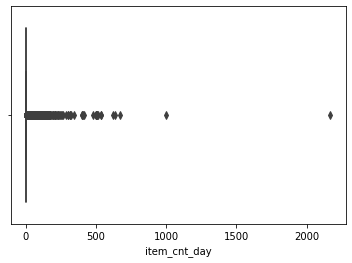

In [132]:
sns.boxplot(full_data['item_cnt_day'])

In [133]:
#full_data = full_data.drop(full_data[full_data['item_cnt_day']>=1000].index)
full_data = full_data.drop(full_data[full_data['item_cnt_day']>=600].index)

In [134]:
full_data.shape

(2928473, 9)

# Feature engineering


Let's make a sales column, very simple using item price and item_cnt_day and multiplying the two values together.

In [135]:
full_data['sales'] = full_data['item_price'] * full_data['item_cnt_day']
full_data.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,sales
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
3,2013-02-01,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
4,2013-03-01,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
5,2013-01-20,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
6,2013-01-23,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
7,2013-01-26,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
8,2013-01-27,0,6,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0
9,2013-10-01,0,15,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0


In [136]:
grouped = full_data.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
grouped.columns = ['item_cnt_month']
grouped.reset_index(inplace=True)
grouped.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


references:
https://jamesrledoux.com/code/group-by-aggregate-pandas



https://www.kaggle.com/jerifate/future-sales-time-series-visualization

In [137]:
agg_dataset = pd.merge(full_data, grouped, how='left', on=['date_block_num', 'shop_id', 'item_id'])
agg_dataset['item_cnt_month'] = (agg_dataset['item_cnt_month'].fillna(0).astype(np.float16))

quick check on what happened.

In [138]:
agg_dataset[(
    agg_dataset['shop_id'] == 31) & (agg_dataset['item_id'] == 4906) & (agg_dataset['date_block_num'] == 0)].head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,sales,item_cnt_month
185790,2013-03-01,0,31,4906,1794.0,2.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19,Игры - PS3,3588.0,11.0
185791,2013-02-01,0,31,4906,1789.0,1.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19,Игры - PS3,1789.0,11.0
185792,2013-12-01,0,31,4906,1799.0,1.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19,Игры - PS3,1799.0,11.0
185793,2013-01-14,0,31,4906,1799.0,1.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19,Игры - PS3,1799.0,11.0
185794,2013-01-19,0,31,4906,1799.0,1.0,"Mortal Kombat. Komplete Edition [PS3, русская ...",19,Игры - PS3,1799.0,11.0


we can also drop duplicates of rows based on the same columns, specifying shop id, item id, date block num, and item cnt month. 

This would eliminate the entries that are from the same shop, same item, with the same amount of item_count a month from the same date block. These are items that are redundant as the item count a month will be the same.

In [139]:
print(agg_dataset.shape)
agg_dataset = agg_dataset.drop_duplicates(['date_block_num','shop_id','item_id','item_cnt_month'])
print(agg_dataset.shape)

(2928473, 11)
(1608214, 11)


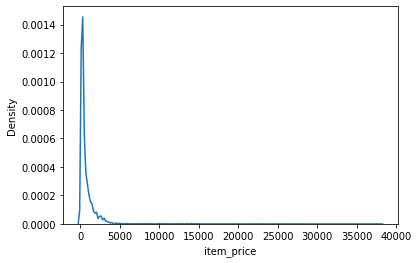

In [140]:
sns.kdeplot(agg_dataset['item_price'])

We already know in advance that the distribution is abnormal because of the heavy amount of upper outliers.A lognormal distribution tends to look quite similar. It may work in fixing our distribution. 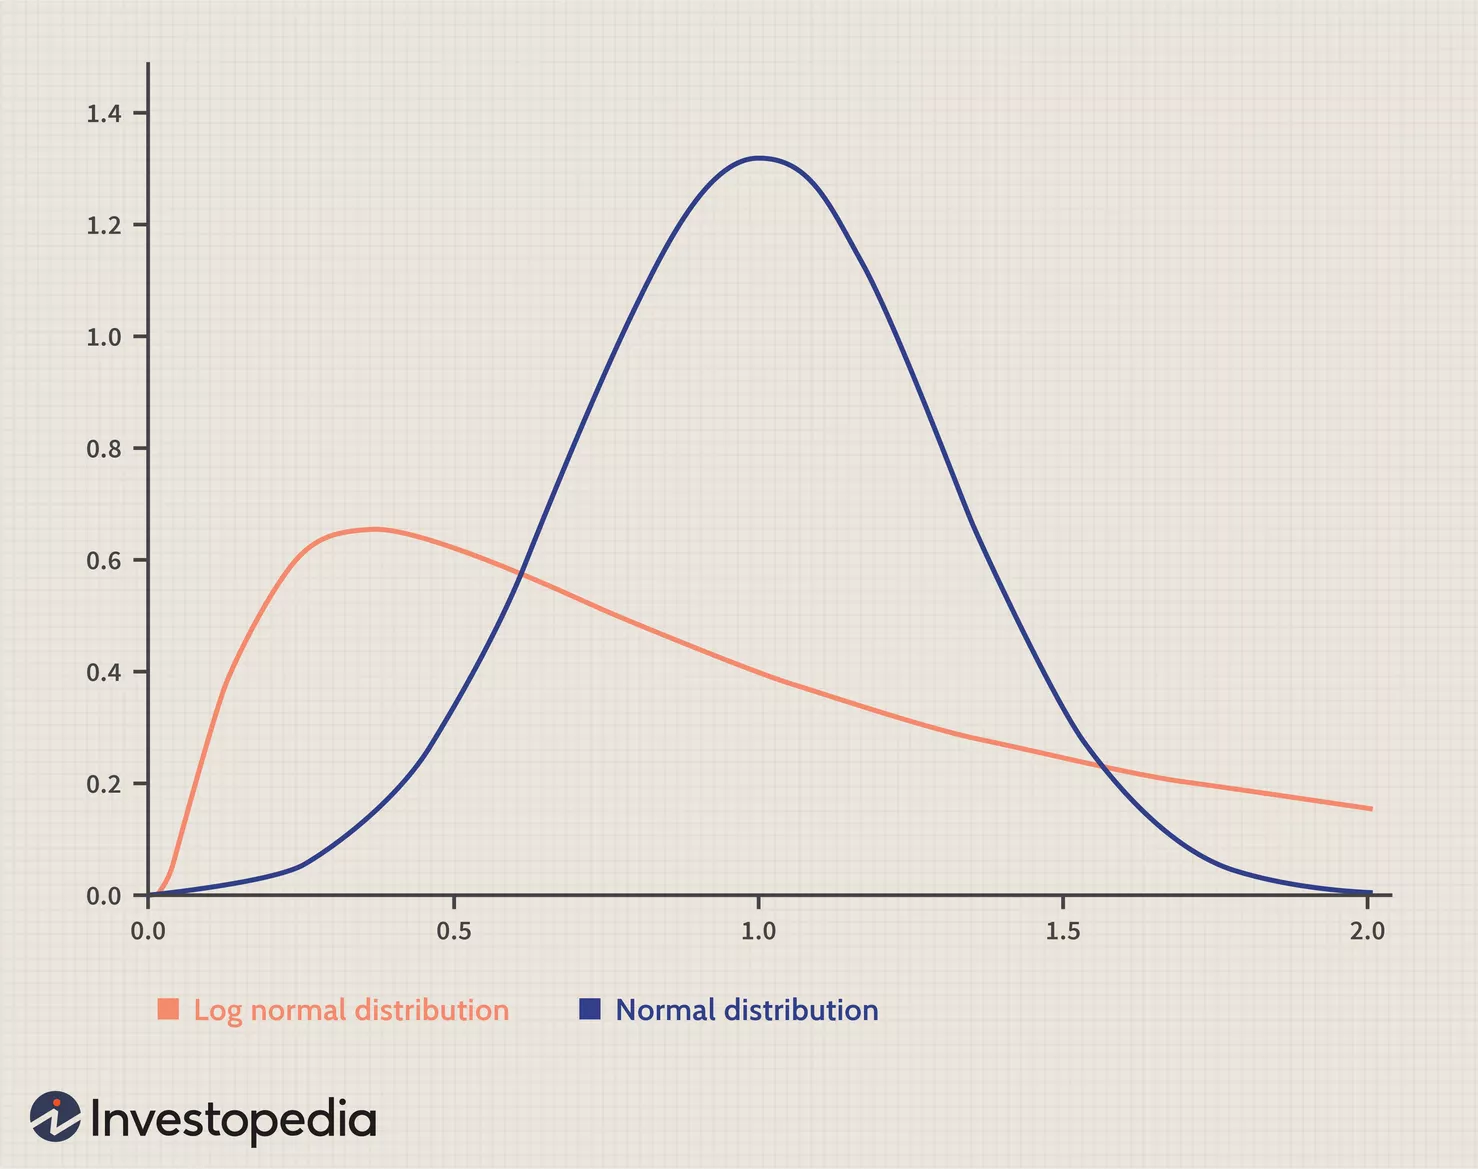

In [141]:
agg_dataset['log_prices'] = np.log1p(agg_dataset['item_price'])
agg_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,sales,item_cnt_month,log_prices
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755
3,2013-02-01,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,5.0,6.907755
8,2013-01-27,0,6,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


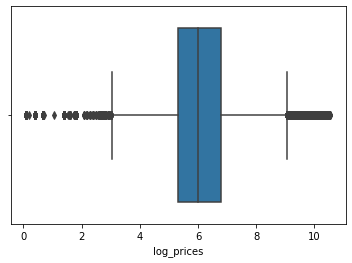

In [142]:
sns.boxplot(agg_dataset['log_prices'])

Dropping useless columns from our data.

In [143]:
agg_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,sales,item_cnt_month,log_prices
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755
1,2013-01-23,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755
2,2013-01-20,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755
3,2013-02-01,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,5.0,6.907755
8,2013-01-27,0,6,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,999.0,1.0,6.907755


In [144]:
agg_dataset = agg_dataset.drop(['date', 'item_price', 'item_cnt_day', 'sales', 'item_category_name', ], axis=1)

In [145]:
agg_dataset.head()

,date_block_num,shop_id,item_id,item_name,item_category_id,item_cnt_month,log_prices
0,0,59,22154,ЯВЛЕНИЕ 2012 (BD),37,1.0,6.907755
1,0,24,22154,ЯВЛЕНИЕ 2012 (BD),37,1.0,6.907755
2,0,27,22154,ЯВЛЕНИЕ 2012 (BD),37,1.0,6.907755
3,0,25,22154,ЯВЛЕНИЕ 2012 (BD),37,5.0,6.907755
8,0,6,22154,ЯВЛЕНИЕ 2012 (BD),37,1.0,6.907755


In [146]:
# agg_dataset = agg_dataset.drop(['item_category_name'], axis=1)

In [147]:
agg_dataset = agg_dataset.drop(['item_name'], axis=1)

In [148]:
print(agg_dataset.shape)
agg_dataset.head()

(1608214, 6)


,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,log_prices
0,0,59,22154,37,1.0,6.907755
1,0,24,22154,37,1.0,6.907755
2,0,27,22154,37,1.0,6.907755
3,0,25,22154,37,5.0,6.907755
8,0,6,22154,37,1.0,6.907755


This looks to be okay. We have removed a lot of the features that were in the set when we merged the items table, and just kept the logprices with item cnt a month as that will be critical to prediction. Then we have shop id item id, but we do not need their names or their category names either. As long as we have their ids, it is much better to deal with numerical values then encoding the string values with something else. 

# Test data engineering

In [149]:
print(test_data.shape)
test_data.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


So here we have an issue of test data not having the same amount of features as the training data. One common way to deal with datasets like this I see quite a bit is to concatenate the two datasets together into a train + test big dataset, then split the big dataset into separate train sets and test sets. This seems to be the simplest way of dealing with it, without a lot of coding. 

In [150]:
test_data['date_block_num'] = 34 
#last date block to fill in the test data, as it is future prediction anyways
test_data.tail()

,ID,shop_id,item_id,date_block_num
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34
214199,214199,45,969,34


In [151]:
item_dict = {}
items_table.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD


In [152]:
item_dict = {key:val for key,val in zip(items_table['item_id'], items_table['item_category_id'])}
print(len(item_dict))

22170


In [153]:
test_datas = test_data.merge(items_table[['item_id', 'item_category_id']], on='item_id', how='left')
test_datas.head()

,ID,shop_id,item_id,date_block_num,item_category_id
0,0,5,5037,34,19
1,1,5,5320,34,55
2,2,5,5233,34,19
3,3,5,5232,34,23
4,4,5,5268,34,20


In [154]:
test_datas['item_category_id'].isna().sum()

0

In [155]:
# test_data.head()

In [156]:
#test_data = test_data.drop('item_category_id_y', axis=1) 
#mistake with adding item category id twice, had to remove
test_data.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [157]:
# test_data['item_cnt_month'] = 0
# test_data = test_data.drop('item_cnt_month', axis=1)
# test_data.head()

In [158]:
#fulltests = pd.merge(test_data, agg_dataset, how='left', on=['item_id', 'shop_id'])
#fulltests.head()

attempt to concatenate datasets using pd.concat, did not work as prices are not being recorded for the items in test data. We can drop the ID column completely but need values for item_cnt_month and log prices. need to find a way to get prices onto test data. 

In [159]:
# train_test = pd.concat(objs=[agg_dataset, test_data], axis=0)
# train_test.tail()


In [160]:
# train_test = pd.merge(test_data, agg_dataset,  
#                               on=['shop_id', 'item_id', 'item_category_id', 'date_block_num'], how='left')
# train_test.shape

In [161]:
test_datas.head()

,ID,shop_id,item_id,date_block_num,item_category_id
0,0,5,5037,34,19
1,1,5,5320,34,55
2,2,5,5233,34,19
3,3,5,5232,34,23
4,4,5,5268,34,20


In [162]:
price_dict = {key:value for key, value in zip(full_data['item_id'], full_data['item_price'])}
#calling back to full data, as item price is not available in agg_dataset.
print(len(price_dict))
logprice_dict = {key:value for key, value in zip(agg_dataset['item_id'], agg_dataset['log_prices'])}
print(len(logprice_dict))
print(logprice_dict)

21799
21799
{22154: 5.703782474656201, 2552: 6.856461984594587, 2554: 7.444277888835313, 2555: 7.047517221357296, 2564: 5.521460917862246, 2565: 6.309918278226516, 2572: 5.703782474656201, 2573: 5.521460917862246, 2574: 6.1092475827643655, 2593: 5.003946305945459, 2604: 5.703782474656201, 2607: 5.703782474656201, 2609: 7.003065458786462, 2548: 7.495541943884256, 2611: 5.703782474656201, 2546: 5.703782474656201, 2515: 7.600902459542082, 2705: 7.495541943884256, 2715: 5.857933154483459, 2716: 5.0106352940962555, 2719: 5.991464547107982, 2720: 5.988961416889864, 2473: 6.802394763324311, 2480: 4.07753744390572, 2731: 6.396929655216146, 2746: 4.543294782270004, 2748: 6.684611727667927, 2522: 7.600902459542082, 2614: 5.703782474656201, 2798: 5.0106352940962555, 2833: 4.59511985013459, 2835: 6.685236532436769, 2836: 7.1693500166706, 2844: 6.110358077048392, 2845: 6.396929655216146, 2847: 5.855071922202427, 2848: 4.07753744390572, 2854: 4.605170185988092, 2857: 6.907755278982137, 2920: 6.21260

In [163]:
price_dict_df = pd.DataFrame.from_dict(price_dict, orient='index', columns=['price'])
price_df = price_dict_df.reset_index()
price_df.columns = ['item_id', 'price']

price_df.head()

,item_id,price
0,22154,299.00
1,2552,949.00
2,2554,1709.05
3,2555,1149.00
4,2564,249.00


In [164]:
logprice_dict_df = pd.DataFrame.from_dict(logprice_dict, orient='index', columns=['price'])
logprice_df = logprice_dict_df.reset_index()
logprice_df.columns = ['item_id', 'log_prices']

logprice_df.head()

,item_id,log_prices
0,22154,5.703782
1,2552,6.856462
2,2554,7.444278
3,2555,7.047517
4,2564,5.521461


In [165]:
# full_test = test_datas.merge(logprice_df, on='item_id',how='left')
# full_test.isna().sum()

a lot of prices are empty. Not good. I will fill with median, better for the set of data we have due to skew. I will have to hold off on adding logprices, and go with real prices and then turn them back into logprices, if I am filling na with median. 

In [166]:
full_test = test_datas.merge(price_df, on='item_id', how='left')
full_test.head()
# full_test.isna().sum()

,ID,shop_id,item_id,date_block_num,item_category_id,price
0,0,5,5037,34,19,1499.0
1,1,5,5320,34,55,NaN
2,2,5,5233,34,19,1199.0
3,3,5,5232,34,23,1199.0
4,4,5,5268,34,20,NaN


In [167]:
full_test.fillna(full_test['price'].median(), inplace=True)
print(full_test['price'].median())
full_test.head()

449.0


,ID,shop_id,item_id,date_block_num,item_category_id,price
0,0,5,5037,34,19,1499.0
1,1,5,5320,34,55,449.0
2,2,5,5233,34,19,1199.0
3,3,5,5232,34,23,1199.0
4,4,5,5268,34,20,449.0


In [168]:
full_test['log_prices'] = np.log(full_test['price'])
full_test.head()

,ID,shop_id,item_id,date_block_num,item_category_id,price,log_prices
0,0,5,5037,34,19,1499.0,7.312553
1,1,5,5320,34,55,449.0,6.107023
2,2,5,5233,34,19,1199.0,7.089243
3,3,5,5232,34,23,1199.0,7.089243
4,4,5,5268,34,20,449.0,6.107023


In [169]:
full_test = full_test.drop('price', axis=1)
full_test.head()

,ID,shop_id,item_id,date_block_num,item_category_id,log_prices
0,0,5,5037,34,19,7.312553
1,1,5,5320,34,55,6.107023
2,2,5,5233,34,19,7.089243
3,3,5,5232,34,23,7.089243
4,4,5,5268,34,20,6.107023


In [170]:
full_test = full_test.drop('ID', axis=1)
full_test.head()

,shop_id,item_id,date_block_num,item_category_id,log_prices
0,5,5037,34,19,7.312553
1,5,5320,34,55,6.107023
2,5,5233,34,19,7.089243
3,5,5232,34,23,7.089243
4,5,5268,34,20,6.107023


# Model Training/Selection

In [171]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from itertools import product

# Modelling
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [172]:
X_train = agg_dataset[agg_dataset.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = agg_dataset[agg_dataset.date_block_num < 33]['item_cnt_month']
X_valid = agg_dataset[agg_dataset.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = agg_dataset[agg_dataset.date_block_num == 33]['item_cnt_month']
X_test = full_test

Linear Regression

In [92]:
lr=LinearRegression()
lr.fit(X_train, Y_train)
print(mean_squared_error(Y_train, lr.predict(X_train)))
print(lr.score(X_train, Y_train))

68.91073818768115
nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:594: RuntimeWarning: overflow encountered in square
  y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


Lasso

In [93]:
lso=Lasso()
lso.fit(X_train, Y_train)
print(mean_squared_error(Y_train, lso.predict(X_train)))
print(lso.score(X_train,Y_train))

68.92658110029699
nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:594: RuntimeWarning: overflow encountered in square
  y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


In [183]:
grad_boost = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100, random_state = 42)
grad_boost.fit(X_train, Y_train) #fitting the model took 2m 24 seconds. 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [89]:
print('Train set mse:', mean_squared_error(Y_train, grad_boost.predict(X_train)))

Train set mse: 43.35131132113967


In [184]:
prediction = grad_boost.predict(X_test)

lightgbm


In [ ]:
# !pip install cmake
# !git clone --recursive https://github.com/Microsoft/LightGBM
# %cd LightGBM
# !mkdir build
# !cd build
# !cmake ./LightGBM
# !make -j4

In [ ]:
# !git clone --recursive https://github.com/Microsoft/LightGBM.git
# %cd LightGBM/python-package
# !python3 setup.py install --gpu

In [174]:
feature_names = X_train.columns.tolist()
params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 15,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1,
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
    'force_row_wise' : True
}

In [81]:
feature_names

['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'log_prices']

In [175]:
feature_cat= ['date_block_num', 'shop_id', 'item_id', 'item_category_id']

In [176]:
lgb_train = lgb.Dataset(X_train[feature_names], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_names], Y_valid, reference=lgb_train)

In [177]:
evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round= 3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_names,
        categorical_feature = feature_cat,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['date_block_num', 'item_category_id', 'item_id', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 7.61956	valid_1's rmse: 6.38278
[100]	training's rmse: 7.12434	valid_1's rmse: 5.91449
[150]	training's rmse: 6.74972	valid_1's rmse: 5.60204
[200]	training's rmse: 6.46492	valid_1's rmse: 5.41077
[250]	training's rmse: 6.22246	valid_1's rmse: 5.21225
[300]	training's rmse: 6.02857	valid_1's rmse: 5.08404
[350]	training's rmse: 5.89299	valid_1's rmse: 5.00242
[400]	training's rmse: 5.77475	valid_1's rmse: 4.95251
[450]	training's rmse: 5.67433	valid_1's rmse: 4.9138
[500]	training's rmse: 5.58719	valid_1's rmse: 4.88375
[550]	training's rmse: 5.51672	valid_1's rmse: 4.86374
[600]	training's rmse: 5.45636	valid_1's rmse: 4.86265
[650]	training's rmse: 5.4073	valid_1's rmse: 4.87605
[700]	training's rmse: 5.36616	valid_1's rmse: 4.87542
Early stopping, best iteration is:
[606]	training's rmse: 5.45058	valid_1's rmse: 4.86253


In [178]:
submission = pd.read_csv('sample_submission.csv.zip', compression='zip')

In [179]:
prediction = gbm.predict(X_test)


In [180]:
submission.head()

,ID,item_cnt_month
0,0,2.044254
1,1,1.537549
2,2,2.044254
3,3,1.918819
4,4,2.449497


In [185]:
submission['item_cnt_month'] = prediction
submission.to_csv('submission2.csv', index=False)

https://www.kaggle.com/jerifate/future-sales-time-series-visualization



https://www.kaggle.com/jeongwonkim10516/ts-eda-pred-on-gpu-orange-visualization/data


Clearly none of the regression based algorithms did great. Our features are mostly categorical so that could only make sense. The model did quite badly, looking at the rmse numbers. The submission also did quite poorly at about 10,000th place. 
One key takeaway is to find better features. I did not perform any feature analysis during my feature engineering stage, did not look at any correlation matrix for that matter, hardly any exploratory analysis at all. Exploratory analysis is as important as the modelling.

In [186]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [187]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [188]:
items_table.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра)
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
